# Combined kernel with kxx, kxf, kff as methods

In [688]:
import numpy as np
import gpjax as gpx
import os
import jax
import matplotlib.pyplot as plt
import jax.random as jr

from dataclasses import dataclass, field

from beartype.typing import Union
import jax.numpy as jnp
from jaxtyping import Float
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from gpjax.base import param_field, static_field
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.typing import (
    Array,
    ScalarFloat,
)

from beartype.typing import Callable
from jaxtyping import Int

from p53_data import JAXP53_Data, dataset_3d, generate_test_times
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams

plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")

# Check if LaTeX is in notebook path
if os.environ.get('PATH') is not None:
    if 'TeX' not in os.environ['PATH']:
        os.environ['PATH'] += os.pathsep + '/Library/TeX/texbin'

colors = rcParams["axes.prop_cycle"].by_key()["color"]

import tensorflow_probability.substrates.jax.bijectors as tfb

key = jr.PRNGKey(42)

In [689]:
p53_data = JAXP53_Data(replicate=2)
training_times, gene_expressions = dataset_3d(p53_data)

In [727]:
p53_data.gene_variances.shape

(1, 5, 7)

### Combined kernel

In [690]:
@dataclass
class latent_kernel(gpx.kernels.AbstractKernel):
    r"Combined covariance for learning the latent replication of p53"

    name: str = "p53 Cov"

    # Define parameters
    # BUG: crashes when using unconstrained parameters

    # Sensitivities of the genes
    initial_constrained_s = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype=jnp.float64)
    initial_unconstrained_s = tfb.Softplus().inverse(initial_constrained_s)

    true_s: Float[Array, "1 5"] = param_field(
        initial_constrained_s,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_sensitivities"},
        trainable=True,
    )

    # Degradation rates of the genes
    initial_constrained_d = jnp.array([0.4, 0.4, 0.4, 0.4, 0.4], dtype=jnp.float64)
    initial_unconstrained_d = tfb.Softplus().inverse(initial_constrained_d)

    true_d: Float[Array, "1 5"] = param_field(
        initial_constrained_d,
        bijector=tfb.Softplus(),
        metadata={"name": " kxx_degradations"},
        trainable=True,
    )

    # Sigmoid to map real numbers to (0,1) and then scales and shifts to get(0.5, 3.5) # NOTE: tfb.Chain acts Right to Left
    l_bijector = tfb.Chain(
        [
            tfb.Shift(jnp.array(0.5, dtype=jnp.float64)),
            tfb.Scale(jnp.array(3.0, dtype=jnp.float64)),
            tfb.Sigmoid(),
        ]
    )

    initial_constrained_l = jnp.array(2.5, dtype=jnp.float64)
    initial_unconstrained_l = l_bijector.inverse(initial_constrained_l)

    l: Float[Array, " O"] = param_field(
        initial_constrained_l, bijector=l_bijector, metadata={"name": "lengthscale"}
    )

    # Redefine parameters as static fields
    #true_s: Float[Array, "1 5"] = static_field(jnp.array([1.0,1.0,1.0,1.0,1.0]))
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.4,0.4,0.4,0.4,0.4]))
    #l: Float[Array, " O"] = static_field(jnp.array(2.5))

    def __call__(self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]) -> ScalarFloat:
        
        # Get flag from input (1 = gene expression, 0 = latent force function)
        f1 = jnp.array(t[2], dtype=int)
        f2 = jnp.array(t_prime[2], dtype=int)

        # Cannot use if statements in kernels -> use switches
        kxx_switch = f1 * f2
        kff_switch = (1 - f1) * (1 - f2)
        kxf_switch = f1 * (1 - f2)
        kxf_t_switch = (1 - f1) * f2

        final_kernel = (
            kxx_switch * self.kernel_xx(t, t_prime)
            + kff_switch * self.kernel_ff(t, t_prime)
            + kxf_switch * self.kernel_xf(t, t_prime)
            + kxf_t_switch * self.kernel_xf(t_prime, t)
        )

        return final_kernel

    def kernel_xx(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        """
        Equation 5 in paper k_xx(t,t')
        """

        # Error trap (JAX friendly)
        def check_validity(condition):
            if condition:
                # raise ValueError("t or t' cannot be testing points (z=0)")
                return 0

        condition = jnp.logical_or(t[2] == 0, t_prime[2] == 0)
        jax.debug.callback(check_validity, condition)

        # Get gene indices
        j = t[1].astype(int)
        k = t_prime[1].astype(int)

        t = t[0]
        t_prime = t_prime[0]

        # Equation 5
        mult = self.true_s[j] * self.true_s[k] * self.l * jnp.sqrt(jnp.pi) * 0.5
        second_term = self.h(k, j, t_prime, t) + self.h(j, k, t, t_prime)

        kxx = mult * second_term
        
        return kxx.squeeze()

    def kernel_xf(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:
        # Get gene expression and latent force from flag (kxf anf kfx are transposes)
        gene_xpr = jnp.where(t[2] == 0, t_prime, t)
        latent_force = jnp.where(t[2] == 0, t, t_prime)

        j = gene_xpr[1].astype(int)

        # Slice inputs
        gene_xpr = gene_xpr[0]
        latent_force = latent_force[0]

        t_dist = jnp.abs(gene_xpr - latent_force)

        first_term = 0.5 * self.l * jnp.sqrt(jnp.pi) * self.true_s[j]
        first_expon_term = jnp.exp(self.gamma(j) ** 2)
        second_expon_term = jnp.exp(-self.true_d[j] * t_dist)
        erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(j)
        ) + jax.scipy.special.erf(latent_force / self.l + self.gamma(j))

        kxf = first_term * first_expon_term * second_expon_term * erf_terms
        return kxf.squeeze()

    def kernel_ff(
        self, t: Float[Array, "1 3"], t_prime: Float[Array, "1 3"]
    ) -> ScalarFloat:

        t = t[0] / self.l
        t_prime = t_prime[0] / self.l

        K = jnp.exp(-0.5 * squared_distance(t, t_prime))

        return K.squeeze()

    # Helper functions
    def h(
        self,
        j: Int[Array, " O"],
        k: Int[Array, " O"],
        t1: Float[Array, " O"],
        t2: Float[Array, " O"],
    ) -> ScalarFloat:
        """
        Analytical solution for the convolution of the exponential kernel with a step function.
        """

        t_dist = t2 - t1

        multiplier = jnp.exp(self.gamma(k) ** 2) / (self.true_d[j] + self.true_d[k])

        first_multiplier = jnp.exp(-self.true_d[k] * t_dist)
        first_erf_terms = jax.scipy.special.erf(
            (t_dist / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(t1 / self.l + self.gamma(k))

        second_multiplier = jnp.exp(-(self.true_d[k] * t2 + self.true_d[j] * t1))
        second_erf_terms = jax.scipy.special.erf(
            (t2 / self.l) - self.gamma(k)
        ) + jax.scipy.special.erf(self.gamma(k))

        result = multiplier * (
            jnp.multiply(first_multiplier, first_erf_terms)
            - jnp.multiply(second_multiplier, second_erf_terms)
        )

        return result

    def gamma(self, k: Int[Array, " O"]) -> ScalarFloat:
        # Gamma term for h function
        return (self.true_d[k] * self.l) / 2


### Custom mean function

The mean function for the gene expressions per time is used to obtain the basal rates:

$$
f(x_{j}) = \frac{B_{j}}{D_{j}} 
$$

In [691]:
# Define custom mean
@dataclass
class latent_mean(gpx.mean_functions.AbstractMeanFunction):
    r"""
    Simple Input Motif mean function

    ```math
        f(x_{j}) = \frac{B_{j}}{D_{j}} 
    ```

    From equation 2 in paper.

    $B_{j}$ represents the basal rate for gene $j$ and is a trainable paramater.
    """

    # Pass kernel instance that contains true_d parameter
    kernel: gpx.kernels.AbstractKernel = field(default_factory=lambda: latent_kernel())
    
    #true_d: Float[Array, "1 5"] = static_field(jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64))
    
    # Define parameters
    initial_constrained_b = jnp.array([0.05, 0.05, 0.05, 0.05, 0.05], dtype=jnp.float64)
    
    true_b: Float[Array, "1 5"] = param_field(initial_constrained_b, bijector=tfb.Softplus(), metadata={"name": " basal_rates"}, trainable=True,)

    def __call__(self, x: Float[Array, "N D"]) -> Float[Array, "N O"]:
        r"""Evaluate the mean function at the given points.

        Args:
            x (Float[Array, " D"]): The point at which to evaluate the mean function.

        Returns
        -------
            Float[Array, "1"]: The evaluated mean function.
        """
        # BUG: Concretization error if this is used ?
        #num_genes = len(jnp.unique(x[:, 1]))
        num_genes = 5

        decays = self.kernel.true_d
        
        block_size = (x.shape[0] // num_genes)
        # Define the mean function
        #mean = (self.true_b / self.true_d).reshape(1, -1)
        mean = (self.true_b / decays).reshape(1, -1)
        mean = mean.repeat(block_size, jnp.newaxis).reshape(-1,1)

        return mean



## GP regression

In [692]:
dataset_train = gpx.Dataset(training_times, gene_expressions)

testing_times = generate_test_times()

In [693]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

meanf = gpx.mean_functions.Zero()
#meanf = latent_mean()
p53_ker = latent_kernel()

posterior = initialise_gp(p53_ker, meanf, dataset_train)

In [694]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset,
    )
    return opt_posterior, history

In [695]:
import optax as ox
jax.config.update("jax_debug_nans", True)

def optimise_mll2(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    print(f'MLL before opt: {objective(posterior, dataset):.3f}')
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit(
        model=posterior,
        objective=objective,
        train_data=dataset, 
        optim=ox.adam(1e-1), 
        num_iters=NIters,
        key=key,
        safe=False)
    return opt_posterior, history

In [696]:
opt_posterior, history = optimise_mll2(posterior, dataset_train)

MLL before opt: 424157.524


  0%|          | 0/1000 [00:00<?, ?it/s]

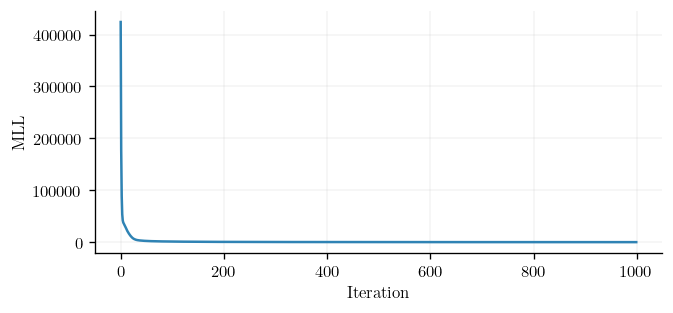

In [697]:
# Plot history of MLL
plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("MLL")
plt.show()

In [588]:
def plot_gp(x_test, predictive_dist):
    """
    Plot LF GP given test points and prediction

    Parameters
    ----------
    x_test: array of shape (n, 3)
    predictive_dist:  jax mvn
    """

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.variance()

    # (100,)
    x_test = x_test[:,0]

    import matplotlib as mpl
    cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    ax.fill_between(
        x_test.squeeze(),
        predictive_mean - 2 * predictive_std,
        predictive_mean + 2 * predictive_std,
        alpha=0.2,
        label="Two sigma",
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean - 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    ax.plot(
        x_test,
        predictive_mean + 2 * predictive_std,
        linestyle="--",
        linewidth=1,
        color=cols[1],
    )
    
    ax.plot(x_test, predictive_mean, label="Predictive mean", color=cols[1])
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.set_xlabel("Time")
    ax.set_ylabel("mRNA Expression")

In [699]:
latent_dist = opt_posterior.predict(testing_times, train_data=dataset_train)

In [700]:
predictive_dist = opt_posterior.likelihood(latent_dist)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(cholesky). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [705]:
plot_gp(testing_times, predictive_dist)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(select_n). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

## Debugging NaNs

In [720]:
cov_matrix = latent_dist.covariance()
assert np.allclose(cov_matrix, cov_matrix.T), "Covariance matrix is not symmetric"
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues <= 0):
    print("Covariance matrix is not positive definite")

Covariance matrix is not positive definite


In [721]:
gram_array = opt_posterior.prior.kernel.gram(dataset_train.X).to_dense()

In [725]:
eigenvalues = np.linalg.eigvalsh(gram_array)
if np.any(gram_array <= 0):
    print("Covariance matrix is not positive definite")

Covariance matrix is not positive definite


In [724]:
jnp.linalg.det(gram_array)

Array(0., dtype=float64)

In [670]:
import cola
from cola.linalg.decompositions.decompositions import Cholesky

from gpjax.dataset import Dataset
from gpjax.distributions import GaussianDistribution
from jaxtyping import Num

class opt_p53_posterior(gpx.gps.ConjugatePosterior):
    
    def custom_predict(self, test_inputs: Num[Array, "N D"], train_data: Dataset) -> GaussianDistribution:
        x, y = train_data.X, train_data.y
        t = test_inputs

        Kxx = self.prior.kernel.gram(x)
        # convert to jnp array
        print(type(Kxx))
        Kxx = Kxx.to_dense()
        print(type(Kxx))
        # BUG: covariance matrix is not PD
        Kxx_inv = jnp.linalg.inv(Kxx)

        Kxf = self.prior.kernel.cross_cov(x, t)
        KfxKxx = jnp.matmul(jnp.transpose(Kxf, (1, 0)), Kxx_inv)
        mean = jnp.matmul(KfxKxx, y)

        Kff = self.prior.kernel.gram(t)
        var = Kff - jnp.matmul(KfxKxx, Kxf)
        var = jnp.expand_dims(var, axis=0)

        # Extract the diagonal
        diag_var = jnp.diagonal(var, axis1=1, axis2=2)

        # Create a diagonal matrix from the extracted diagonal
        var = jnp.diag(diag_var)

        # Add jitter for numerical stability
        var += jitter * jnp.eye(var.shape[-1])


        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), var)

In [671]:
custom_posterior = opt_p53_posterior(prior=opt_posterior.prior, likelihood=opt_posterior.likelihood)

latent2 = custom_posterior.custom_predict(testing_times, train_data=dataset_train)

<class 'cola.ops.operators.Dense'>
<class 'jaxlib.xla_extension.ArrayImpl'>


FloatingPointError: invalid value (nan) encountered in jit(triangular_solve). Because jax_config.debug_nans.value and/or config.jax_debug_infs is set, the de-optimized function (i.e., the function as if the `jit` decorator were removed) was called in an attempt to get a more precise error message. However, the de-optimized function did not produce invalid values during its execution. This behavior can result from `jit` optimizations causing the invalid value to be produced. It may also arise from having nan/inf constants as outputs, like `jax.jit(lambda ...: jax.numpy.nan)(...)`. 

It may be possible to avoid the invalid value by removing the `jit` decorator, at the cost of losing optimizations. 

If you see this error, consider opening a bug report at https://github.com/google/jax.

In [659]:
cov2 = latent2.covariance()

In [665]:
cov_matrix2 = latent2.covariance()
assert np.allclose(cov_matrix2, cov_matrix2.T), "Covariance matrix is not symmetric"
eigenvalues2 = np.linalg.eigvalsh(cov_matrix2)
if np.any(eigenvalues2 <= 0):
    print("Covariance matrix is not positive definite")

print(jnp.all(cov_matrix == cov_matrix2))

Covariance matrix is not positive definite
False
